In [1]:
%matplotlib inline
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Datasetの読み込み

In [2]:
train_data = torchvision.datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = torchvision.datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Image batch shape [batch_size : 64, color : 1, width : 28, height : 28]
Labels batch shape : 64


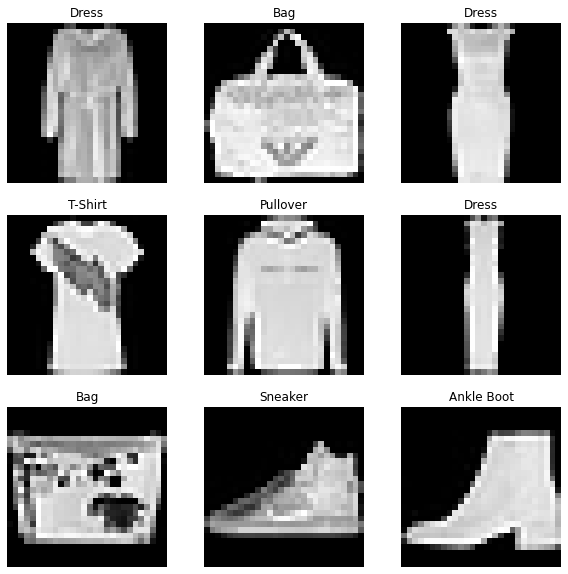

In [3]:
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)
# 辞書型変数にまとめると学習・検証の実施時に扱いやすくなる
dataloaders_dict = {"train" : train_dataloader, "test" : test_dataloader}
# イテレータに変換
batch_iterator = iter(dataloaders_dict["train"])
# 要素を取り出す
imgs, labels = next(batch_iterator)
print("Image batch shape [batch_size : %d, color : %d, width : %d, height : %d]"
      % (imgs.size()[0], imgs.size()[1], imgs.size()[2], imgs.size()[3]))
print(f"Labels batch shape : {labels.size()[0]}")

# 訓練データの表示
figure = plt.figure(figsize = (10, 10))
rows, cols = 3, 3
for i in range(rows * cols):
    idx = torch.randint(low = 0, high = len(imgs), size = (1, 1)).item()
    # データの取得
    img, label_num = imgs[idx], labels[idx].item()
    figure.add_subplot(cols, rows, i + 1)
    plt.title(labels_map[label_num])
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap = "gray")
plt.show()

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.loss_train_log = []
        self.loss_test_log = []
        self.acc_train_log = []
        self.acc_test_log = []
        
        # 1つの入力画像チャンネル、4 x 4の正方形畳み込み、32つの出力チャンネル
        self.Conv1 = nn.Conv2d( 1, 32, kernel_size = (4, 4), stride = (2, 2), padding = 1)
        # 32つの入力画像チャンネル、4 x 4の正方形畳み込み、64つの出力チャンネル
        self.Conv2 = nn.Conv2d(32, 64, kernel_size = (4, 4), stride = (2, 2), padding = 1)
        self.linear1 = nn.Linear(64 * 3 * 3, 128)
        self.linear2 = nn.Linear(128, 10)
        #self.Softmax = nn.Softmax(dim = 1)
        
        # 誤差関数の設定
        self.loss = nn.CrossEntropyLoss() 
        # 最適化手法の設定
        self.optimizer = optim.SGD(self.parameters(), lr = 1e-2)
        
    def forward(self, x):
        x = self.Conv1(x) # Size : 1 x 28 x 28 -> 32 x 14 x 14
        x = torch.relu(x)
        x = self.Conv2(x) # Size : 32 x 14 x 14 -> 64 x 7 x 7
        x = torch.relu(x)
        x = F.max_pool2d(x, 2) # 指定サイズの範囲内で最大の値を抽出する(Size : 64 x 7 x 7 -> 64 x 3 x 3)
        x = x.view(-1, 64 * 3 * 3) # ベクトルに変換
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return x
    
model = CNN()

epoch : 1
loss_train : 1.3577713609250115, acc_train : 0.554904043674469
loss_test  : 0.8918555861066102, acc_test : 0.6796377301216125
epoch : 10
loss_train : 0.413428917558971, acc_train : 0.8496968150138855
loss_test  : 0.500506765428622, acc_test : 0.815784215927124
epoch : 20
loss_train : 0.3306573586169082, acc_train : 0.8782649040222168
loss_test  : 0.35559438320861503, acc_test : 0.8729100227355957
epoch : 30
loss_train : 0.28874325079481994, acc_train : 0.8932569026947021
loss_test  : 0.34681123172401623, acc_test : 0.8737062215805054


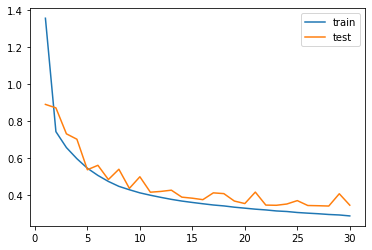

In [5]:
for epoch in range(30): # エポック数分ループを回す
    loss_train = 0.0
    acc_train = 0.0
    loss_test = 0.0
    acc_test = 0.0
    
    # 学習
    for (x, t) in train_dataloader:
        # パラメータの勾配をリセット
        model.optimizer.zero_grad()
        # 順伝搬＋逆伝搬＋パラメータ更新
        y = model(x)
        loss = model.loss(y, t)
        loss.backward()
        model.optimizer.step()
        # 統計情報の記録
        loss_train += loss.item()
        acc_train += sum(y.argmax(axis=1) == t) / len(t)
        
    # 検証
    with torch.no_grad(): # テストでは勾配を求める必要がないので、勾配を求めないように設定
        for x, t in test_dataloader:
            y = model(x)
            loss = model.loss(y, t)
            loss_test += loss.item()
            acc_test += sum(y.argmax(axis=1) == t) / len(t)
            
    # 結果の記録・表示
    model.loss_train_log.append(loss_train / len(train_dataloader))
    model.loss_test_log.append(loss_test / len(test_dataloader))
    if epoch == 0 or epoch % 10 == 9:
        print(f"epoch : {epoch + 1}")
        print(f"loss_train : {loss_train / len(train_dataloader)}, acc_train : {acc_train / len(train_dataloader)}")
        print(f"loss_test  : {loss_test / len(test_dataloader)}, acc_test : {acc_test / len(test_dataloader)}")
        
# Lossのログ表示
plt.plot(range(1, len(model.loss_train_log) + 1), model.loss_train_log, label = "train")
plt.plot(range(1, len(model.loss_test_log) + 1),  model.loss_test_log,  label = "test")
plt.legend(loc = "upper right") # 凡例表示
torch.save(model, "../model/cnn_fashion-mnist.pth") # モデルの保存

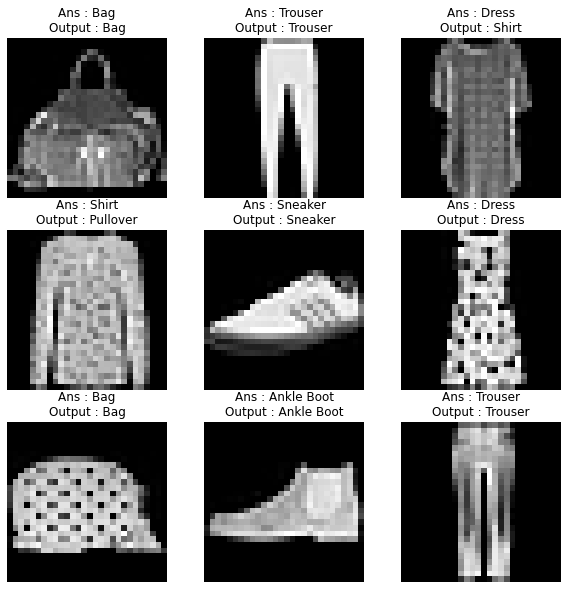

In [6]:
# 推論結果の表示
figure = plt.figure(figsize = (10, 10))
rows, cols = 3, 3
for i in range(rows * cols):
    idx = torch.randint(low = 0, high = len(imgs), size = (1, 1)).item()
    # データの取得
    img, label = imgs[idx], labels[idx]
    figure.add_subplot(cols, rows, i + 1)
    plt.title(f"Ans : {labels_map[label.item()]}\nOutput : {labels_map[model(img).argmax(axis=1).item()]}")
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap = "gray")
plt.show()